## Loading Dependacies And Selecting Device:

In [548]:
#Uncomment if use Colab
'''from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) #mount google drive
'''

#Dependancies
%matplotlib inline
import torch
from torch import nn
import matplotlib.pyplot as plt

import datetime
import random
import math
import numpy

#Selects device (CPU or GPU - Selecting GPU allows for faster processing)
print("Cuda Available: " + str(torch.cuda.is_available()))
#Checks if cuda is enabled
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#Indicates if the GPU has bee
print("Device is: " + str(device))

#Makes default tensor a cuda optimised tensor if cuda is selected as the device 
if str(device) == "cuda":
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

print("\n>> Done")

Cuda Available: True
Device is: cuda

>> Done


## Producting Training And Validation Data:

In [549]:
#TRAINING DATA
Nf = 2000 #The number of different functions f that we will generate
Npts = 40 #The number of x values that we will use to generate each fa
x = torch.zeros(Nf, Npts, 1) #Makes an Nf x Npts x 1 tensor of 0s

#Creates 40 points (Npts) for the 2000 (Nf) functions
for k in range(Nf):
    #Creates a one-dimensional tensor of size Npt - whose values are evenly spaced from -2 to 2
    x[k,:,0] = torch.linspace(-2, 2, Npts) #The second dimention (":") is replaced with a linespace

#torch.rand_like - Returns a tensor with the same size as x that is filled with random numbers from a uniform distribution
#The genarated values are each incremented by a randome value between 0 and 1 multiplied by 0.1
x += torch.rand_like(x)*0.1 #Adds noise

#torch.rand(nf) - Returns a tensor filled with random numbers from a uniform distribution (of size nf)
#view(-1,1) - transposed a
#repeat(1, Npts) - Repeats this tensor along the specified dimensions
#unsqueeze - Returns a new tensor with a dimension of size 2 inserted at the specified position
a = -2 + 4*torch.rand(Nf).view(-1,1).repeat(1, Npts).unsqueeze(2)
y = a*torch.sin(x+a) #y = fa(x) = a ∗ sin(x + a)

print("\n>> Done")


>> Done


## Dataset And Dataloader:
(A portion of the 2000 datapoints defined above are selected and stored as trainig data and the rest is selected and stored as validation data in a dataloader with a given batch size)

In [550]:
#Dataset implementatio that will hold the Xt and Yt data
class sinFuncDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        #Stores features (the set of xt) and labelts (the set of yt) sperately
        self.features = features 
        self.labels = labels
        
    #Return the length of the dataset
    def __len__(self):
        return len(self.features)
        
    #Gets the features and labels of a selected function (indexed by "fPossition") from the set of functions (features and corresponding labels) stored in this dataset.
    def __getitem__(self, fPossition):
        #Stores a 2D copy of the featuers and labels of the indexed function 
        featuresOfFunction = self.features[fPossition].view(-1)
        labelsOfFunction = self.labels[fPossition].view(-1)

        #Returns a tuple with the input and output data of the sampled functions
        return (featuresOfFunction, labelsOfFunction)

print("\n>> Done")


>> Done


In [677]:
#Sets dataloader batch size
batchSize = 32 #40 / 50

#Splits the 2000 family of functions into a set of features and labels that will be used for testing (1800 of the first featues and labels) - there is a set of features and labels that will be used for validation (200 of the last featues and labels)
testFeatures = x[:1800]
testLabels = y[:1800]
#Creates a dataset and dataloader with the data above
trainingDataset = sinFuncDataset(testFeatures, testLabels)
trainingLoader = torch.utils.data.DataLoader(trainingDataset, batch_size=batchSize, shuffle=True)

#Uses the rest of the data for validation 
validationFeatures = x[200:]
validationLabels = y[200:]
#Creates a dataset and dataloader with the data above
validationDataset = sinFuncDataset(validationFeatures, validationLabels)
validationLoader = torch.utils.data.DataLoader(validationDataset, batch_size=batchSize, shuffle=True)

#Full dataset - this will have all 2000 features and label pairs (incase we use seperate validation data)
fullDataset = sinFuncDataset(x, y)
fullDatasetLoader = torch.utils.data.DataLoader(fullDataset, batch_size=batchSize, shuffle=False)

print("\n>> Done")


>> Done


## Encoder, Decoder And Model:
(The Encoder and Decoder are seperate models which are combined in "Model" (a single model))

In [678]:
#The Encoder will take the tensor with the context pairs and feed it into multiple linear regression layers to get rdim many outputs. The Tanh activation function will be used inbetween layers to add Non-linearities 
class Encoder(nn.Module):
    def __init__(self, inpSize=2, hDim=2, rDim=2):
        super(Encoder, self).__init__()
        #Models and activation functions
        self.linLayer1 = nn.Linear(inpSize, hDim)
        self.activationFunc1 = nn.Tanh()
        self.linLayer2 = nn.Linear(hDim, hDim)
        self.activationFunc2 = nn.Tanh()
        self.linLayer3 = nn.Linear(hDim, rDim) 

        #intialises model weights (with a uniform distribution) and bais(with 0)
        torch.nn.init.normal_(self.linLayer1.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer1.bias)  
        torch.nn.init.normal_(self.linLayer2.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer2.bias)  
        torch.nn.init.normal_(self.linLayer3.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer3.bias)   
         
    #Returns the output of feeding the input features into the first defined linear model, a Tanh activation function and then the second defined linear model, then another Tanh activation function and finally a 3rd linear model
    def forward(self, contextData):  
        linLayerOut1 = self.linLayer1(contextData)
        activationOut1 = self.activationFunc1(linLayerOut1)
        linLayerOut2 = self.linLayer2(activationOut1)
        activationOut2 = self.activationFunc2(linLayerOut2)
        linLayerOut3 = self.linLayer3(activationOut2)
        
        #Returns the mean of the output (which will be a single value - per input features provided)
        return torch.mean(linLayerOut3, 1, True)

print("\n>> Done")


>> Done


In [679]:
#The Decoder will recieve a tensor with the 40 input features, with the encoder's oupt (which will be a single 1xrDim value for each set of features in the batch) appened onto each feature, and it will feed it into several linear regression layer to get a single output/prediction for each input feature. It will use the Tanh activation function to add Non-linearities in between linear layers. The output will be a single prediction per each 40 input feature, per batch ([batch size] x [40] x [1] output)
class Decoder(nn.Module):
    def __init__(self, inpSize=3, outSize=1, hDim=2):
        super(Decoder, self).__init__()
        #Models and activation functions
        self.linLayer1 = nn.Linear(inpSize, hDim)
        self.activationFunc1 = nn.Tanh()
        self.linLayer2 = nn.Linear(hDim, hDim)  
        self.activationFunc2 = nn.Tanh()
        self.linLayer3 = nn.Linear(hDim, outSize)  

        #Intialises model weights and bais
        torch.nn.init.normal_(self.linLayer1.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer1.bias)  
        torch.nn.init.normal_(self.linLayer2.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer2.bias)  
        torch.nn.init.normal_(self.linLayer3.weight, std=0.01) 
        torch.nn.init.zeros_(self.linLayer3.bias)  
         
    #Feeds the data set into the models and activation function defined above
    def forward(self, inputData):
        linRegOut1 = self.linLayer1(inputData)
        activationOut1 = self.activationFunc1(linRegOut1)
        linRegOut2 = self.linLayer2(activationOut1)
        activationOut2 = self.activationFunc2(linRegOut2)
        linRegOut3 = self.linLayer3(activationOut2)

        return linRegOut3
    
print("\n>> Done")


>> Done


In [680]:
#Combines the encoder and decoder into a single model which processes the input inbetween the 2 to make the appropriate modifications
class Model(nn.Module):
    def __init__(self, ctxDim=2, outDim=1, rDim=2, hDim=4):
        super(Model, self).__init__()
        #ctxDim is 2 since we have 2 pairs of context point, which we will feed into the model
        self.encoder = Encoder(ctxDim, hDim, rDim)
        #rDim + 1 - the size of the output (1) plus the rc value (Which will have Rdim elements), which is appendeded to it (rc is the output of the decoder)
        self.decoder = Decoder((rDim + 1), outDim, hDim)

    #Glues together the encoder and decoder by combining the encoder's output to the decoder's input and feeding that combination to the decoder
    def forward(self, contextPairs, inputFeatures):
        #Formats the context data so it can be fet into the encoder
        encoderInput = torch.stack((contextPairs[0], contextPairs[1]),-1)
        #Feets the formated intput data to the encoder
        encoderOutput = self.encoder(encoderInput)
        #Makes a new tensor with comprised of the encoded output repeated 40 times (one for each input feature)
        encoderOutputR = encoderOutput.repeat(1, inputFeatures.size(-1), 1)
        #Concatinates the input features with the encoder's output (which is repeated across each input feature) 
        decoderInput = torch.cat((encoderOutputR, inputFeatures.unsqueeze(-1)), dim=2)
        #Feeds the concatinated tensor to the decoder
        decoderOutput = self.decoder(decoderInput)
        #returns the output of the decoder
        return decoderOutput.squeeze(-1)

print("\n>> Done")


>> Done


## Context Selector Function:
(Used In Traing Script To Select Context Points From The Dataset Of A Batch)

In [681]:
#Selects context data for a batch given the xt and yt values the that context point will be a subset of
def selectContexts(xt, yt):
    #Selects a random number between 6 (randLowerB) and 35 (randUpperB) to be the selected number of context points
    randLowerB = 5
    randUpperB = 35
    randNoOfContexts = random.randint(randLowerB, randUpperB)

    #Records the batch size
    bSize = xt.size(0)
    
    #Selects the indexes of the feature and labels that will be selected as the context data
    contextIndexes = []
    for i in range(randNoOfContexts):
        index = random.randint(0,(Npts - 1))
        if index in contextIndexes:
            while index in contextIndexes:
                index = random.randint(0,(Npts - 1))
        contextIndexes.append(index)
    #Sorts indacies so the contexts can be retrieved in order
    contextIndexes.sort()
    
    #Creates a [batch size] x [randomn number of contexts choose] tensor, filled with zeros, to store the context points for each batch
    paddedXContexts = torch.zeros(bSize, randNoOfContexts)
    paddedYContexts = torch.zeros(bSize, randNoOfContexts) 

    #Uses the selected random indexes to select columns of inputs features and labels (a pair of inputs features and labels per set of features in the batch) to be used as context data. The selected colomns of context data are stored in the aformenetioned tensor
    for i in range(randNoOfContexts):
        paddedXContexts[:,i] = xt[:,contextIndexes[i]]
        paddedYContexts[:,i] = yt[:,contextIndexes[i]]

    #Returns a tuple with the input and output data of the sampled functions
    return (paddedXContexts, paddedYContexts)

print("\n>> Done")


>> Done


## Validation Function:
 (Used In Traing Script To Carry Out Validation)

In [682]:
#Validates models for a single epoch with validation data, which is then recorded and returned to be used later
def validateModel(model, dataLoader, optimiser):
    accumlativeBatchLoss = 0.0 #Stores the total loss of the dataset
    batchLossPerFHistory = [] #Stores the history of the average loss per batch

    #Goes through the provided dataset (the validation dataset)
    for data in dataLoader:
        #Unpacks data so it can be fed to the model
        (features, groundTruth) = data
        (xContext, yContexts) = selectContexts(features, groundTruth)

        #Selects a device to compute on
        xContext.to(device)
        yContexts.to(device)
        features.to(device)
        groundTruth.to(device)

        #Sets the optimiser's gradients to 0 then feeds the data into the model to get predictions from it
        optimiser.zero_grad()
        predictions = model((xContext, yContexts), features)
        
        #Compares the predictions to the ground truth and calculates loss. The loss is then recorded and accumilated 
        loss = lossFunction(predictions, groundTruth)
        currentLoss = loss.item() 
        batchLossPerFHistory.append(currentLoss) #Stores the average loss per batch
        accumlativeBatchLoss += currentLoss #Accumilates the average loss per batch
        
    averageLoss = accumlativeBatchLoss / len(dataLoader) #Gets an average loss by deviding the total loss of all batches by the number of batches to get an overall loss for the the whole dataset

    return averageLoss, batchLossPerFHistory

print("\n>> Done")


>> Done


## Training Script:
(Both trains and validates each epoch)

In [683]:
def trainer(model, dataLoader, vDataloader, optimiser, noOfEpoch=1, printPerEpoch=1, progressBarInterval=1, progressSeperatorInterval=0, traceEpochLoss=False, traceBatchLoss=False):
    progressBarCount = 0

    #Holds losss 
    accumlativeBatchLoss = 0.0 #Total loss for batch
    accumlativeEpochLoss = 0.0 #Total loss for epoch
    accumlativeLoss = 0.0 #Total loss for epoch
  
    #Gets the model ready to train
    model.train(True) #Sets model to training mode
    torch.set_grad_enabled(True) #Tracks gradients

    #Makes sure the progress bar rate is not above the specified inteval in which the progress of a set of epochs is printed
    if printPerEpoch < progressBarInterval:
        progressBarInterval = printPerEpoch

    #Arrays for tracking the history of loss per epoch and per batch - the training function returns these
    epochLossHistory = []
    batchLossHistory = []
    batchLossPerFHistory = []
    #Tracks the loss during validation
    validationLossHistory = []
    validationLossPerFHistory = []

    timeBeforeFirstEpoch = datetime.datetime.now() #Records the time before the first epoch
    datasetSize = len(dataLoader.dataset) #Gets the size of the dataset in the dataloader

    #Strings for progress bars when tracking per group of epochs
    for epoch in range(noOfEpoch):
        #Sets the epoch loss to every new epoch
        accumlativeEpochLoss = 0.0
        accumlativeLoss = 0.0

        #Adds seperator to string output to indicate a new epoch has started
        if printPerEpoch > 1 and epoch % printPerEpoch == 0 and epoch != 0:
            print("]")
            print("----------------------------------------------------\n")
        #Prints an indication of which epoch is being sampled and having it's batch loss printed
        if printPerEpoch > 1 and epoch % printPerEpoch == 0 and traceBatchLoss == True:
            print("[Batch Loss For Sample Epoch <" + str(epoch) + ">]")
            print(".......................................................")

        #Tracks time taken per epoch or group of epochs
        if traceEpochLoss == True and (epoch % printPerEpoch == 1 or epoch == 0 or printPerEpoch == 1):
            startTime = datetime.datetime.now()

        #Counts the amount of data that has been iterated through during the epoch
        progressCounter = 1 

        #Goes through data loader to train model for the current epoch
        for data in dataLoader:
            #Loads data into seperate variables
            (features, groundTruth) = data
            #Selects context points for encoder using the data extracted from the datalaoder
            (xContext, yContexts) = selectContexts(features, groundTruth)

            #Attempts to use GPU/CUDA for processing the dataset
            xContext.to(device)
            yContexts.to(device)
            features.to(device)
            groundTruth.to(device)

            #Set the parameter gradients to 0
            optimiser.zero_grad()
            #Feeds the model the context data and features
            predictions = model((xContext, yContexts), features)
            
            #Calculates and stores the loss
            loss = lossFunction(predictions, groundTruth)

            #Trains the model
            loss.backward()
            optimiser.step()

            #Record the amount of data that has been accumalatively used for training at at the current batch
            progressCounter += features.size(0)

            #Retrieves the batch's loss
            currentLoss = loss.item() 
            #Accumilates each batch's loss during the epoch - resets per epoch
            accumlativeEpochLoss += currentLoss
            #Records the total loss (the average loss multplied by the batch size)
            accumlativeLoss += currentLoss * features.size(0)     

            #This loss is used to find the average loss per a given set of epoch - minus the first one
            if epoch != 0:
                accumlativeGroupEpochLoss += currentLoss

            #Stores the batch loss over time - per batch
            batchLossHistory.append(currentLoss)

            #If epoch trace flag is set, this prints the batch loss of current epoch
            if traceEpochLoss == True and traceBatchLoss == True and epoch % printPerEpoch == 0:
                print("---- Batch " + str(progressCounter) + ": loss (per batch) = " + str(currentLoss))

        #Stores the loss over time - per epoch
        epochLossHistory.append(accumlativeEpochLoss)

        #Records the rate of loss per epoch (where accumlativeLoss is the batch's average loss * the numbr of features processed in the batch (which is between 1 and the batch size) and dataset Size is the length of the dataset that we are going through per epoch
        lossRateChange = accumlativeLoss / datasetSize 
        #Stores the average loss per epoch, per set of features assessed
        batchLossPerFHistory.append(lossRateChange) 

        #Calls the validateModel function - which validates the newly trained model every epoch (with seperate validation data) and returns the average loss as well as each batch loss 
        model.eval()
        with torch.no_grad():
            vLoss, vLossPF = validateModel(model, vDataloader, optimiser)
            validationLossHistory.append(vLoss)
            validationLossPerFHistory.append(vLossPF)
        model.train(True)

        ''' OUTPUT FORMATING FOR TRACING PROGRESS AND LOSS PER INTERVAL '''
        #If epoch trace flag is set, prints info about the current epoch or set of processed epochs
        if traceEpochLoss == True and epoch % printPerEpoch == 0:
            if traceBatchLoss == True:
                print(".......................................................")
                print("\n>>>> Epoch Done! <<<<\n")
                print("<=====================================================>")
            else:
                print("Loss Statistics Of Sample (Epoch [" + str(epoch+1) + "]):")
                print("<=====================================================>")

            #Prints the average loss per featre assessed for the whole epoch
            print("Loss (Per Input, Per Epoch): " + str(lossRateChange))

            #For groups of epochs, this prints the average lost per batch, per epoch
            if epoch == 0:
                print("Loss (Per Batch, Per Epoch): " + str(accumlativeEpochLoss))
            else:
                print("Average Loss After " + str(printPerEpoch) + " Epoch(s) (Per Batch, Per Epoch): " + str(accumlativeGroupEpochLoss/printPerEpoch))

            #Prints the time take for the group of epoch/single epoch
            endTime = datetime.datetime.now()
            timeTakesForEpoch = endTime - startTime
            timeTakesForEpochStr = ""
            if timeTakesForEpoch > datetime.timedelta(seconds=1):
                timeTakesForEpochStr = str(timeTakesForEpoch).split(".")[0]
            else:
                timeTakesForEpochStr = str(timeTakesForEpoch.microseconds / 1000) + " ms"

            print("<=====================================================>")

            if epoch == 0:
                print("Time Taken: " + timeTakesForEpochStr)
            else:
                print("Time Taken For " + str(printPerEpoch) + " Epochs: " + timeTakesForEpochStr)

            if epoch == 0:
                timeAfterFirstEpoch = datetime.datetime.now() #Records the time after the first epoch is complete
                estimatedTimeForAllEpochs = (timeAfterFirstEpoch - timeBeforeFirstEpoch) * noOfEpoch
                print("\n>> Estimated Time To Complete " + str(noOfEpoch) + " Epochs: " + str(str(estimatedTimeForAllEpochs).split(".")[0]) + " <<")
            
            #If the epoch trace flag is set, this insidcates the current epoch
            if printPerEpoch > 1:
                progressLeft = epoch + printPerEpoch
                if noOfEpoch % printPerEpoch != 0 and epoch == (printPerEpoch * (noOfEpoch // printPerEpoch)):
                    progressLeft = epoch + (noOfEpoch % printPerEpoch)
                print("\n----------------------------------------------------")
                print("Epochs Currently being Processed: [" + str(epoch + 1) + "-" + str(progressLeft) + "] <Epoch Group: " + str((int(math.ceil(noOfEpoch/(1/((epoch+1)/noOfEpoch))))//printPerEpoch) + 1) + "/" + str(noOfEpoch//printPerEpoch) + "> ")
            else:
                print("\nCurrent Epoch [" + str(epoch+1) + "]: ")

            #Prints the progress of each group of epochs
            if printPerEpoch > 1:
                print("\nProgress: \n[#", end='')
                progressBarCount += 1

        #Prints "#" to indicate the progress of a group of epochs
        if (printPerEpoch > 1) and (not(epoch % printPerEpoch == 0)) and (epoch % progressBarInterval == 0):
            print("#", end='')
            progressBarCount += 1
            if progressSeperatorInterval != 0 and progressBarCount % progressSeperatorInterval == 0 and (epoch + progressBarInterval) % printPerEpoch != 0 and epoch > 1:
                print("|", end='')

        #Resets the loss recorded for the group of epochs
        accumlativeGroupEpochLoss = 0.0

    #Formats the progress bar after the last epoch
    if printPerEpoch > 1:
        print("]")
        print("----------------------------------------------------")
    
    print("\n" + (str(noOfEpoch) + " Epochs completed."))

    #Returns the epoch and batch lost history
    return epochLossHistory, batchLossHistory, batchLossPerFHistory, validationLossHistory, validationLossPerFHistory

        
print("\n>> Done")


>> Done


## Optimizer And Loss:
(Declares the model and optimiser, specifies hyper parameters and specifies the input and output sizes to be used in the model)

RUN THIS TO UNTRAIN THE MODEL

In [684]:
#Loss function initialisation
lossFunction = nn.MSELoss()

#def lossFunction(prediction, groundTruth):
    #loss = (prediction - groundTruth).pow(2).sum()

#Model dimentions
ctxDim = 2 #The number of set of contexts that the encoder will recieve (the input size of the encoder)
outDim = 1 #The output size of the decoder
hDim = 240 #Determines the size of the input and outputs of the hidden layers of the model
rDim = 8 #The size of the encoder's output

#Model initialisation
myModel = Model(ctxDim, outDim, rDim, hDim)
myModel.to(device)

#Hyperparameter initialisation
learningRate = 0.001 #0.001
weightDecay = 0.0005

#Optimiser initilisation
myOptimizer = torch.optim.Adam(myModel.parameters(), lr=learningRate) #, weight_decay=weightDecay)

epochLossHistoryTrain = []

print(myModel)
print("\n>> Done")

Model(
  (encoder): Encoder(
    (linLayer1): Linear(in_features=2, out_features=240, bias=True)
    (activationFunc1): Tanh()
    (linLayer2): Linear(in_features=240, out_features=240, bias=True)
    (activationFunc2): Tanh()
    (linLayer3): Linear(in_features=240, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (linLayer1): Linear(in_features=9, out_features=240, bias=True)
    (activationFunc1): Tanh()
    (linLayer2): Linear(in_features=240, out_features=240, bias=True)
    (activationFunc2): Tanh()
    (linLayer3): Linear(in_features=240, out_features=1, bias=True)
  )
)

>> Done


## Training:
(Calls the training function and store the loss of the model per epoch - which the trainer returns)

In [685]:
#Trainer Params
noOfEpochs = 800 #Number of epochs that the model is trained for
printPerEpoch = (noOfEpochs//1) #From the last group of epochs that had statistics about them printed, this defines the number of epochs, from that point, that will be executed before the next print out
progressBarInterval = ((printPerEpoch//100)*2) #The number of executed epochs each "#" in the progress bar represents
progressSeperatorInterval = 5 #The inteval in which a "|" is inserted into the progress bar as a seperator
traceEpochLoss = True #If true, infromation about the current epoch (or the first epich in a group of epochs if printPerEpoch is more than 1) is printed out - including the average loss during that epoch
traceBatchLoss = False #Prints the loss of each batch for the current epoch (or the first in a group of epochs if printPerEpoch is more than 1)

#Trains the model - which returns statistics about it's loss
#Note: If the model has been trained before (and statistics aobut it's loss was collected after it was trained), we append it's loss statistics/results to the arrays that already holds infromation about it's loss during pass traing attempts
if len(epochLossHistoryTrain) == 0:
    print("<>=======================================<>")
    print("||  Training New Model For " + str(noOfEpochs) + " Epochs!  ||" )
    print("<>=======================================<>\n\n")
    epochLossHistoryTrain, batchLossHistoryTrain, genTrainLoss, validationLoss, validationLossPF = trainer(myModel, trainingLoader, validationLoader, myOptimizer, noOfEpochs, printPerEpoch, progressBarInterval, progressSeperatorInterval, traceEpochLoss=True)
else:
    print("<>===========================================<>")
    print("||  Contining Training For " + str(noOfEpochs) + " More Epochs!  ||" )
    print("<>===========================================<>\n\n")
    epochLossHistoryTrain_, batchLossHistoryTrain_, genTrainLoss_, validationLoss_, validationLossPF_ = trainer(myModel, trainingLoader, validationLoader, myOptimizer, noOfEpochs, printPerEpoch, progressBarInterval, progressSeperatorInterval, traceEpochLoss=True)
    #Appends the new loss history onto the array with the old hsitoy
    epochLossHistoryTrain = numpy.append(epochLossHistoryTrain, epochLossHistoryTrain_)
    batchLossHistoryTrain = numpy.append(batchLossHistoryTrain, batchLossHistoryTrain_) 
    genTrainLoss = numpy.append(genTrainLoss, genTrainLoss_)  
    validationLoss = numpy.append(validationLoss, validationLoss_)  
    validationLossPF = numpy.append(validationLossPF, validationLossPF_) 
    
print("\n>> Done")

<>=======================================<>
||  Training New Model For 800 Epochs!  ||
<>=======================================<>


Loss Statistics Of Sample (Epoch [1]):
<=====================================================>
Loss (Per Input, Per Epoch): 0.41402222050560844
Loss (Per Batch, Per Epoch): 23.724768549203873
<=====================================================>
Time Taken: 363.0 ms

>> Estimated Time To Complete 800 Epochs: 0:04:50 <<

----------------------------------------------------
Epochs Currently being Processed: [1-800] <Epoch Group: 1/1> 

Progress: 
[#####|#####|#####|#####|#####|#####|#####|#####|#####|#####]
----------------------------------------------------

800 Epochs completed.

>> Done


## Loss Graphing:
(Uses the loss data retrieved from the trainer to visual present/graph the traing and validation loss)

Points to plot: 800

>> Done


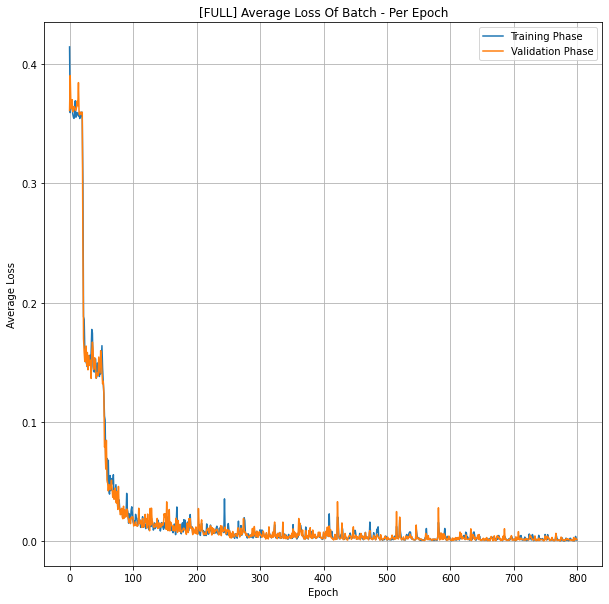

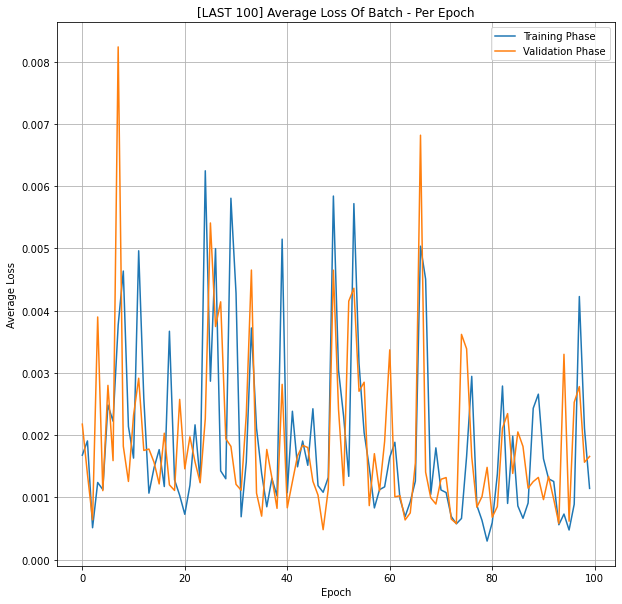

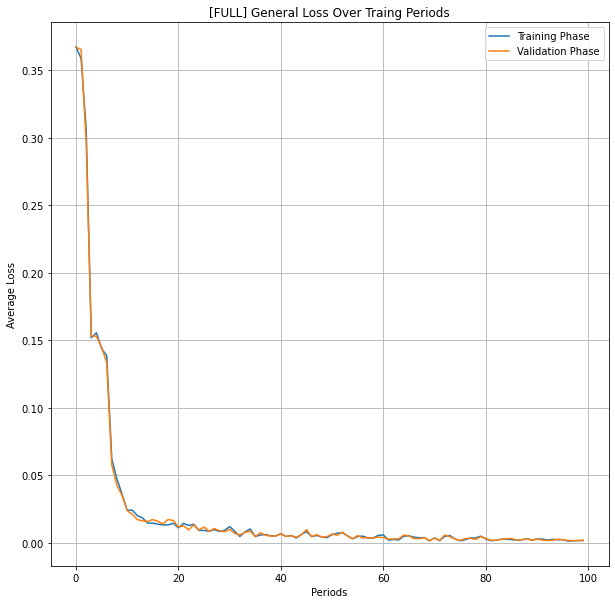

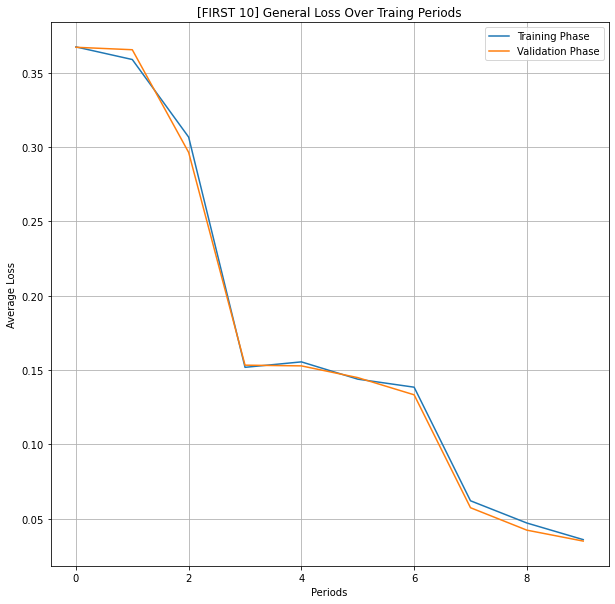

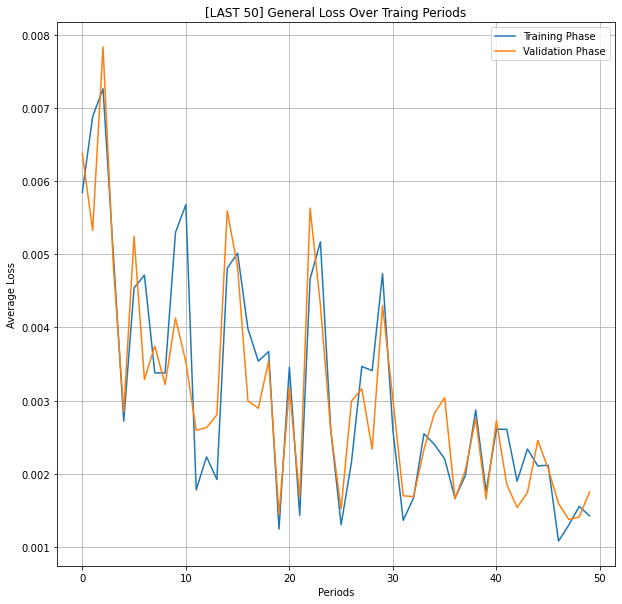

In [686]:
def graphHistory(trBatchHistory, trEpochHistory, trLossPerInp, valBatchHistory, valEpochHistory):
    plt.subplots(1, figsize=(10,10))
    plt.title("[FULL] Average Loss Of Batch - Per Epoch")
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")  
    plt.plot(trLossPerInp, label="Training Phase")
    plt.plot(validationLoss, label="Validation Phase") 
    plt.legend(loc="upper right")

    if len(trLossPerInp) < 100:
        lastFew = len(trLossPerInp)
    else:
        lastFew = 100

    plt.subplots(1, figsize=(10,10))
    plt.title("[LAST " + str(lastFew) + "] Average Loss Of Batch - Per Epoch")
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")  
    plt.plot(trLossPerInp[-lastFew:], label="Training Phase")
    plt.plot(validationLoss[-lastFew:], label="Validation Phase") 
    plt.legend(loc='upper right')

    #Summerises the training and validation loss history into 100 points to show a more general representation of the loss
    onePercentOfResSet = len(trLossPerInp)//100
    resSummanyT = []
    resSummanyV = []
    for i in range(100):
        resSummanyT.append(sum(trLossPerInp[(onePercentOfResSet*(i)):(onePercentOfResSet*(i+1))])/onePercentOfResSet)
        resSummanyV.append(sum(validationLoss[(onePercentOfResSet*(i)):(onePercentOfResSet*(i+1))])/onePercentOfResSet)

    plt.subplots(1, figsize=(10,10))
    plt.title("[FULL] General Loss Over Traing Periods")
    plt.grid()
    plt.xlabel("Periods")
    plt.ylabel("Average Loss")  
    plt.plot(resSummanyT, label="Training Phase")
    plt.plot(resSummanyV, label="Validation Phase") 
    plt.legend(loc='upper right')

    plt.subplots(1, figsize=(10,10))
    plt.title("[FIRST 10] General Loss Over Traing Periods")
    plt.grid()
    plt.xlabel("Periods")
    plt.ylabel("Average Loss")  
    plt.plot(resSummanyT[:10], label="Training Phase")
    plt.plot(resSummanyV[:10], label="Validation Phase") 
    plt.legend(loc='upper right')

    plt.subplots(1, figsize=(10,10))
    plt.title("[LAST 50] General Loss Over Traing Periods")
    plt.grid()
    plt.xlabel("Periods")
    plt.ylabel("Average Loss")  
    plt.plot(resSummanyT[-50:], label="Training Phase")
    plt.plot(resSummanyV[-50:], label="Validation Phase") 
    plt.legend(loc='upper right')
    
    '''
    plt.subplots(1, figsize=(10,10))
    plt.title('Total Loss Of Batch - Per Epoch')
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel("Total Loss In Batch")
    plt.plot(trEpochHistory)

    plt.subplots(1, figsize=(10,10))
    plt.title('Ploted Loss Per Batch')
    plt.grid()
    plt.xlabel("Batch")
    plt.ylabel("Average Loss Of Batch")          
    plt.plot(trBatchHistory, '*')
    '''

print("Points to plot: " + str(len(genTrainLoss)))
graphHistory(batchLossHistoryTrain, epochLossHistoryTrain, genTrainLoss, validationLossPF, validationLoss)
 
print("\n>> Done")

# Test data:

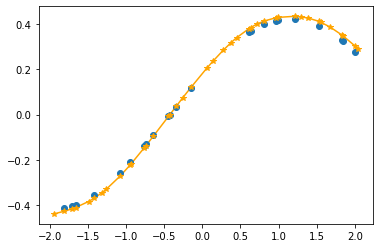

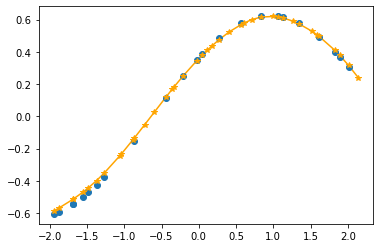

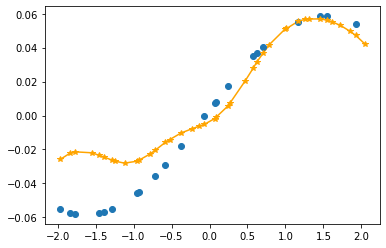

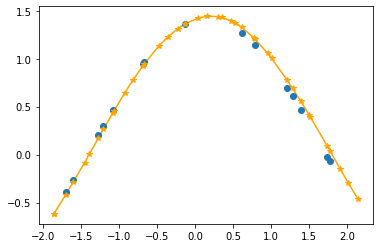

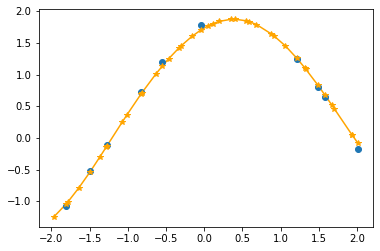

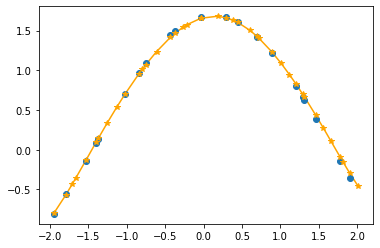

In [687]:
import pickle
path_to_the_pickle = 'test_data.pkl'
test_data = pickle.load(open(path_to_the_pickle,'rb'))

# 6 test functions - plots them on seperate graphs
for i in range(1,7):
    name = 'function_num_{}'.format(i)
    x_c = test_data[name]['context_pairs'][0].squeeze(-1).to(device)
    y_c = test_data[name]['context_pairs'][1].squeeze(-1).to(device)
    x_t = test_data[name]['x'].squeeze(-1).to(device)

    y_t = myModel((x_c, y_c), x_t)

    plt.subplots(1) 
    plt.plot(x_t[0].cpu(), y_t[0].cpu().detach().numpy(), color='orange') #plots prediction as a line - peplace x_t[0] with prediction
    plt.plot(x_c[0].cpu(), y_c[0].cpu(), 'o') #plots example contexts
    plt.plot(x_t[0].cpu(), y_t[0].cpu().detach().numpy(), '*', color='orange') #plots prediction as a line - peplace x_t[0] with 